In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os

# Load dataset
root = '../data/'
path = 'ml_features_subset.csv'
df = pd.read_csv(os.path.join(root,path))

# Convert time column to datetime if needed and sort by date
df["date"] = pd.to_datetime(df["date"])
df.drop(columns=['rt_prices', 'da_prices'], inplace= True)
df = df[['price_error', 'n_spikes_30', 'wind_speed', 'precipitation', 'hdd', 'cdd', 'past_da_load_error', 'past_da_price_error', 'month', 'hour', 'is_weekend', 'is_holiday',
         'load_capacity_ratio' ]]

target_col = "price_error"  # Replace with your target column name

# Drop rows with NaN values resulting from lag feature creation
df.dropna(inplace=True)

# Define feature set by excluding the date and target columns
features = [col for col in df.columns if col not in ["date", target_col]]
X = df[features]
y = df[target_col]

# Split into train and test sets without shuffling (to maintain time order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Output feature importances
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate model performance using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")



Feature Importances:
                feature  importance
5   past_da_price_error    0.203141
10  load_capacity_ratio    0.157228
4    past_da_load_error    0.120620
0           n_spikes_30    0.113549
1            wind_speed    0.102953
3                   cdd    0.096959
2                   hdd    0.079896
7                  hour    0.068683
6                 month    0.043170
8            is_weekend    0.013785
9            is_holiday    0.000016
Mean Squared Error: 15781.4120


In [58]:
correlation_with_target = df.corr()[target_col].sort_values(ascending=False)

# Display the correlation table
print("Correlation of all features with the target:")
print(correlation_with_target)

Correlation of all features with the target:
price_error            1.000000
n_spikes_30            0.187704
past_da_price_error    0.069904
cdd                    0.056608
month                  0.036613
wind_speed             0.004523
load_capacity_ratio   -0.001334
is_holiday            -0.003361
is_weekend            -0.004304
hour                  -0.012007
past_da_load_error    -0.013520
hdd                   -0.027159
Name: price_error, dtype: float64


Feature Importances:
                feature  importance
5   past_da_price_error    0.168190
10  load_capacity_ratio    0.145398
4    past_da_load_error    0.143271
1            wind_speed    0.136928
0           n_spikes_30    0.097499
2                   hdd    0.092690
7                  hour    0.091877
3                   cdd    0.057272
6                 month    0.050419
8            is_weekend    0.016435
9            is_holiday    0.000020
Random Forest AUC: 0.8071


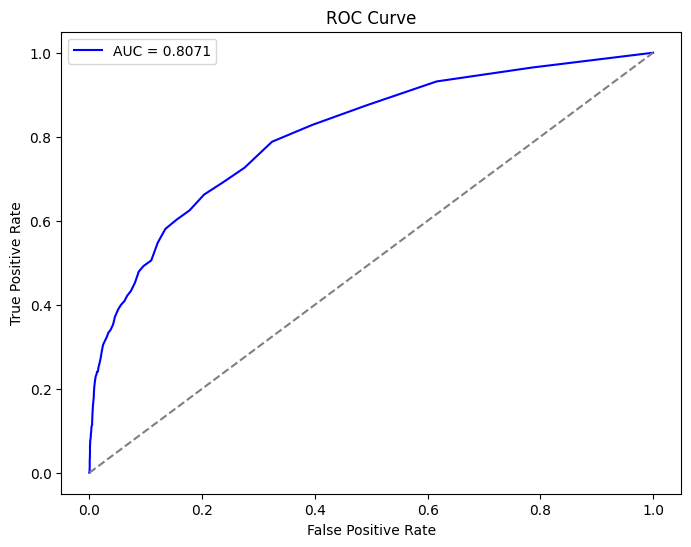

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

df = pd.read_csv(os.path.join(root,path))
df = df[['price_error', 'n_spikes_30', 'wind_speed', 'precipitation', 'hdd', 'cdd', 'past_da_load_error', 'past_da_price_error', 'month', 'hour', 'is_weekend', 'is_holiday',
         'load_capacity_ratio' ]]

# Split data into train and test sets
df[target_col] = (df[target_col] > 30).astype(int)
X = df[features]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get predicted probabilities for the positive class (1)
y_probs = rf_model.predict_proba(X_test)[:, 1]

feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

# Compute AUC
auc = roc_auc_score(y_test, y_probs)
print(f"Random Forest AUC: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
